In [1]:
import pyspark
from pyspark import SparkContext as sc
from pyspark import SparkConf
conf=SparkConf().setAppName("DBSCAN").setMaster("local[*]")
sc=sc.getOrCreate(conf)

### The code of DBSCAN

ref:https://towardsdatascience.com/an-efficient-implementation-of-dbscan-on-pyspark-3e2be646f57d

In [11]:
from pyspark.sql import Row
import math
from graphframes import *
from itertools import combinations


def __distance_from_pivot(pivot, dist, epsilon, operations):
    def distance(x):
        pivot_dist = dist(x.value, pivot)
        if operations is not None:
            operations.add()
        partition_index = math.floor(pivot_dist / epsilon)
        rows = [Row(id=x.id, value=x.value, pivot_dist=dist(x.value, pivot))]
        out = [(partition_index, rows),
               (partition_index + 1, rows)]
        return out
    return distance


def __scan(epsilon, dist, operations):
    def scan(x):
        # out dictionary would have point id as key and a set of point ids who are within epsilon distance to
        # key point id. value is basically its neighbors
        out = {}
        # 0th index of x is partition_index
        # 1st index of x is data points
        partition_data = x[1]
        partition_len = len(partition_data)
        for i in range(partition_len):
            for j in range(i + 1, partition_len):
                if operations is not None:
                    operations.add()
                if dist(partition_data[i].value, partition_data[j].value) < epsilon:
                    # both i and j are within epsilon distance to each other
                    if partition_data[i].id in out:
                        out[partition_data[i].id].add(partition_data[j].id)
                    else:
                        out[partition_data[i].id] = set([partition_data[j].id])
                    if partition_data[j].id in out:
                        out[partition_data[j].id].add(partition_data[i].id)
                    else:
                        out[partition_data[j].id] = set([partition_data[i].id])
        # returns point and its neighbor as tuple
        return [Row(item[0], item[1]) for item in out.items()]

    return scan


def __label(min_pts):
    def label(x):
        if len(x[1]) + 1 >= min_pts:
            # use id as cluster label
            cluster_label = x[0]
            # return True for core point
            out = [(x[0], [(cluster_label, True)])]
            for idx in x[1]:
                # return False for base point
                out.append((idx, [(cluster_label, False)]))
            return out
        return []

    return label


def __combine_labels(x):
    # 0th element is the id of point
    # 1st element is the list of tuples with cluster and core point label
    point = x[0]
    core_point = False
    cluster_labels = x[1]
    clusters = []
    for (label, point_type) in cluster_labels:
        if point_type is True:
            core_point = True
        clusters.append(label)
    # if core point keep all cluster otherwise only one
    return point, clusters if core_point is True else [clusters[0]], core_point


def process(spark, df, epsilon, min_pts, dist, dim, checkpoint_dir, operations=None):
    """
    Process given dataframe with DBSCAN parameters
    :param spark: spark session
    :param df: input data frame where each row has id and value keys
    :param epsilon: DBSCAN parameter for distance
    :param min_pts: DBSCAN parameter for minimum points to define core point
    :param dist: method to calculate distance. Only distance metric is supported.
    :param dim: number of dimension of input data
    :param checkpoint_dir: checkpoint path as required by Graphframe
    :param operations: class for managing accumul1ator to calculate number of distance operations
    :return: A dataframe of point id, cluster component and boolean indicator for core point
    """
    zero = [0] * dim
    combine_cluster_rdd = df.rdd.\
        flatMap(__distance_from_pivot(zero, dist, epsilon, operations)). \
        reduceByKey(lambda x, y: x + y).\
        flatMap(__scan(epsilon, dist, operations)). \
        reduceByKey(lambda x, y: x.union(y)).\
        flatMap(__label(min_pts)).\
        reduceByKey(lambda x, y: x + y).map(__combine_labels).cache()
    id_cluster_rdd = combine_cluster_rdd.\
        map(lambda x: Row(point=x[0], cluster_label=x[1][0], core_point=x[2]))
    try:
        id_cluster_df = id_cluster_rdd.toDF()
        vertices = combine_cluster_rdd.\
            flatMap(lambda x: [Row(id=item) for item in x[1]]).toDF().distinct()
        edges = combine_cluster_rdd. \
            flatMap(lambda x: [Row(src=item[0], dst=item[1])
                               for item in combinations(x[1], 2)]). \
            toDF().distinct()
        spark.sparkContext.setCheckpointDir(checkpoint_dir)
        g = GraphFrame(vertices, edges)
        connected_df = g.connectedComponents()
        id_cluster_df = id_cluster_df.\
            join(connected_df, connected_df.id == id_cluster_df.cluster_label). \
            select("point", "component", "core_point")
        return id_cluster_df
    except ValueError:
        return None

In [69]:
dim = 2
dist = distance.euclidean
epsilon = 3.6
min_pts = 2
zero = [0] * dim
X = np.array(load_point('dataset/spiral.txt'))
data = [(i, [float(item) for item in X[i]]) for i in range(X.shape[0])]
schema = T.StructType([T.StructField("id", T.IntegerType(), False),
                                   T.StructField("value", T.ArrayType(T.FloatType()), False)])
df = spark.createDataFrame(data, schema=schema)
operations=None
combine_cluster_rdd = df.rdd.\
        flatMap(__distance_from_pivot(zero, dist, epsilon, operations)). \
        reduceByKey(lambda x, y: x + y).\
        flatMap(__scan(epsilon, dist, operations)). \
        reduceByKey(lambda x, y: x.union(y)).\
        flatMap(__label(min_pts)).\
        reduceByKey(lambda x, y: x + y).map(__combine_labels).cache()
# id_cluster_rdd = combine_cluster_rdd.\
#     map(lambda x: Row(point=x[0], cluster_label=x[1][0], core_point=x[2]))
# print(combine_cluster_rdd.take(10))
# print(id_cluster_rdd.take(10))
id_cluster_df = id_cluster_rdd.toDF()
vertices = combine_cluster_rdd.\
    flatMap(lambda x: [Row(id=item) for item in x[1]]).toDF().distinct()
edges = combine_cluster_rdd. \
    flatMap(lambda x: [Row(src=item[0], dst=item[1])
                       for item in combinations(x[1], 2)]). \
    toDF().distinct()
# print(edges.head(10))
spark.sparkContext.setCheckpointDir("checkpoint")
g = GraphFrame(vertices, edges)
connected_df = g.connectedComponents()
print(connected_df.show(10))
print(id_cluster_df.show(10))
id_cluster_df = id_cluster_df.\
    join(connected_df, connected_df.id == id_cluster_df.cluster_label). \
    select("point", "component", "core_point")
print(id_cluster_df.show(10))

+---+---------+
| id|component|
+---+---------+
| 26|        0|
| 29|        0|
| 65|        0|
|191|      106|
|270|      207|
|222|      207|
|293|      207|
|243|      207|
|278|      207|
| 54|        0|
+---+---------+
only showing top 10 rows

None
+-----+-------------+----------+
|point|cluster_label|core_point|
+-----+-------------+----------+
|  106|          106|      true|
|  108|          106|      true|
|  110|          108|      true|
|  112|          110|      true|
|  114|          112|      true|
|  116|          114|      true|
|  118|          116|      true|
|  120|          118|      true|
|  122|          118|      true|
|  124|          120|      true|
+-----+-------------+----------+
only showing top 10 rows

None
+-----+---------+----------+
|point|component|core_point|
+-----+---------+----------+
|   30|        0|      true|
|   29|        0|      true|
|  276|      207|      true|
|  277|      207|      true|
|  286|      207|      true|
|  285|      207|   

In [3]:
def load_point(path):
    points = sc.textFile(path).map(lambda x: x.strip().split()[:-1]).map(lambda x: tuple([float(i) for i in x]))
    return points.collect()

In [4]:
def load_label(path):
    points = sc.textFile(path).map(lambda x: x.strip().split()[-1:]).map(lambda x: tuple([float(i) for i in x]))
    return points.collect()

In [5]:
def plain_picture(fileName, ax):
    # draw original plot
    X = np.array(load_point(fileName))
#     labels_true = np.array(load_label(fileName))
    
    ax[0].plot(X[:, 0], X[:, 1], 'o', markerfacecolor=[0, 0, 0, 1],
                 markeredgecolor='k', markersize=3, scalex=1, scaley=1)
    ax[0].set_title('plot of '+fileName[8:-4])
    data = [(i, [float(item) for item in X[i]]) for i in range(X.shape[0])]
    schema = T.StructType([T.StructField("id", T.IntegerType(), False),
                                   T.StructField("value", T.ArrayType(T.FloatType()), False)])
    return X, data, schema

In [6]:
def processed_picture(X, ax, N, labelList,fileName):
    N += 1

    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    bounds = np.linspace(0,N,N+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
#     fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(6,6))
    scat = ax[1].scatter([i[0] for i in X],[i[1] for i in X],c=labelList,s=None,cmap=cmap,norm=norm)
    cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
    cb.set_label('Custom cbar')
    ax[1].set_title('DBSCAN Result of '+fileName[8:-4])
    plt.show()

In [7]:
def triangle_dbscan(fileName, epsilon, min_pts, ax):
    X, data, schema = plain_picture(fileName,ax)
    
    start_time = time.time()
    
    df = spark.createDataFrame(data, schema=schema)
    df_clusters = process(spark, df, epsilon, min_pts, distance.euclidean, 2, "checkpoint")
    
    # process the result
    tupleList = [{'point':x["point"], 'component':x["component"], 'core_point':x["core_point"]} 
             for x in df_clusters.rdd.collect()]
    clusterList={}
    for i in tupleList:
      clusterList[i['point']]=i

    cate = []
    for i in tupleList:
      cate.append(i['component'])
    cate = list(set(cate))
    cateMap = dict(zip(cate,range(len(cate))))

    labelList = []
    for i in range(len(X)):
      if i in clusterList.keys():
        labelList.append(cateMap[clusterList[i]['component']])
      else:
        labelList.append(len(cate))
        
    end_time = time.time()
    print('triangle_dbscan run time on '+fileName[8:]+':', end_time - start_time)
        
    processed_picture(X, ax, len(cate), labelList, fileName)

use some clustering datasets and see its performance in the DBSCAN

triangle_dbscan run time on spiral.txt: 77.9185402393341


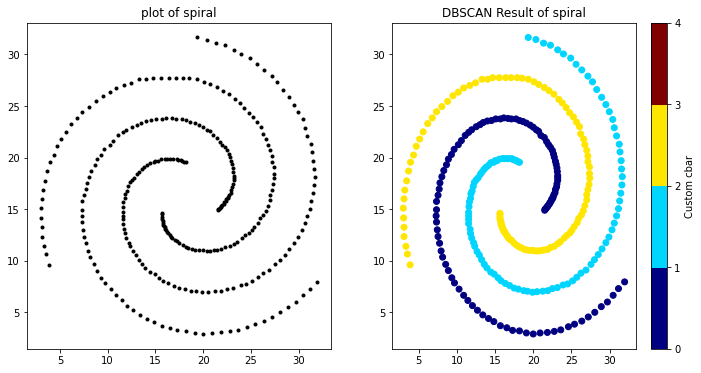

In [13]:
from pyspark.sql import types as T, SparkSession
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import time
spark = SparkSession.builder.appName("DBSCAN").config('spark.driver.host', '127.0.0.1').getOrCreate()
from scipy.spatial import distance
fig, ax = plt.subplots(1,2, figsize=(12,6))
triangle_dbscan('dataset/spiral.txt', 3.6, 2, ax)

triangle_dbscan run time on flame.txt: 57.3948872089386


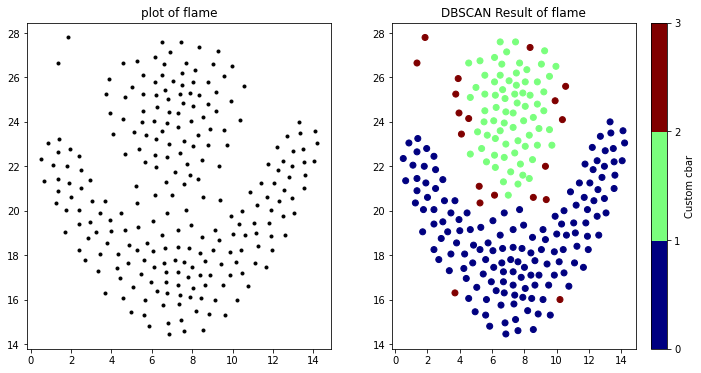

In [14]:
fig1, ax1 = plt.subplots(1,2, figsize=(12,6))
triangle_dbscan('dataset/flame.txt', 0.8, 3, ax1)

triangle_dbscan run time on R15.txt: 31.802777767181396


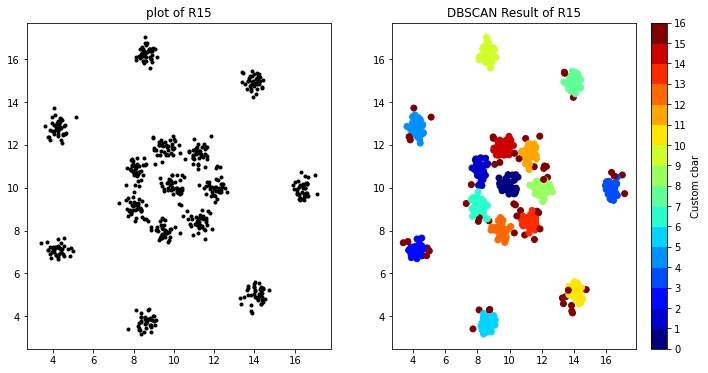

In [15]:
fig2, ax2 = plt.subplots(1,2, figsize=(12,6))
triangle_dbscan('dataset/R15.txt', 0.3, 5, ax2)

triangle_dbscan run time on D31.txt: 52.17403030395508


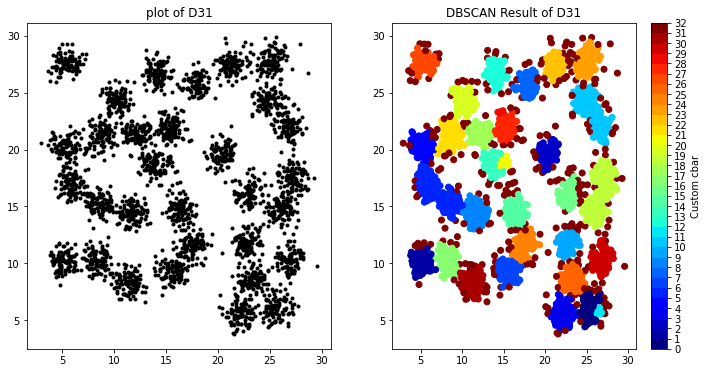

In [21]:
fig1, ax1 = plt.subplots(1,2, figsize=(12,6))
triangle_dbscan('dataset/D31.txt', 0.48, 6, ax1)

triangle_dbscan run time on t80.txt: 243.00481700897217


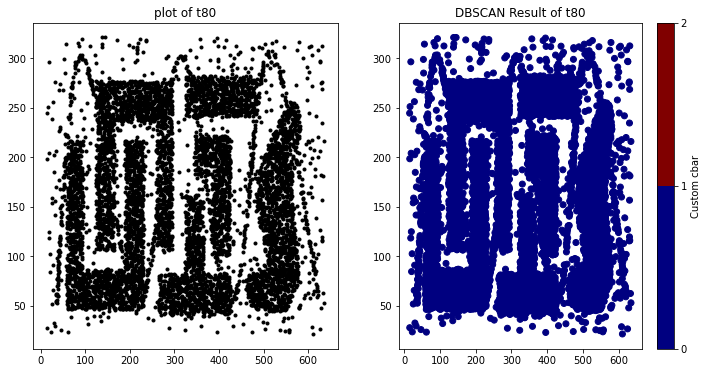

In [9]:
fig1, ax1 = plt.subplots(1,2, figsize=(12,6))
triangle_dbscan('dataset/t80.txt', 30, 5, ax1)